#  1. Making a dataset of assets, their prices and their volumes

## 1.1. Getting the data downloaded

In [5]:
# 1.1.1. A function to import daily yahoo finaance data

def import_yahoo_data(ticker, start_date, end_date):
    import yfinance as yf
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Ticker'] = ticker
    return df

# 1.1.2. A function to run the function above for each asset 
# and merge it into a df indexed by ticker and then by date

def import_multiple_assets(tickers, start_date, end_date):
    import pandas as pd
    all_data = []
    for ticker in tickers:
        df = import_yahoo_data(ticker, start_date, end_date).reset_index()
        df.columns = ["Date","Close", "High", "Low", "Open", "Volume", "Ticker"]
        df = df.set_index(['Date', 'Ticker'])
        #keep all in float64 for memory efficiency
        df = df.astype({'Close': 'float32', 'High': 'float32', 'Low': 'float32', 'Open': 'float32', 'Volume': 'float32'})
        all_data.append(df)
    combined_df = pd.concat(all_data)
    return combined_df

## 1.2. Adding the asset by asset features 

In [ ]:
# 1.3 Calculating asset level features
def add_features(df):
    import pandas as pd; import numpy as np
    df = df.sort_index(level=['Ticker', 'Date'])
    
    df['Return_lag_1'] =  df.groupby(level='Ticker')['Close'].transform(lambda x: x / x.shift(1) - 1)
    df['Return_lag_5'] = df.groupby(level='Ticker')['Close'].transform(lambda x: x / x.shift(5) - 1)
    df['Return_lag_20'] = df.groupby(level='Ticker')['Close'].transform(lambda x: x / x.shift(20) - 1)
    df['Past_Sharpe_roll5_lag_1'] = df.groupby(level='Ticker')['Return_lag_1'].shift(1).rolling(window=5).mean() / df.groupby(level='Ticker')['Return_lag_1'].shift(1).rolling(window=5).std() * (252**0.5)
    df['Past_Sharpe_roll5_lag_2'] = df.groupby(level='Ticker')['Return_lag_1'].shift(2).rolling(window=5).mean() / df.groupby(level='Ticker')['Return_lag_1'].shift(2).rolling(window=5).std() * (252**0.5)
    df['RollingMean_5_lag_1'] = df.groupby(level='Ticker')['Close'].transform(lambda x: x.rolling(window=5).mean()).shift(1)
    df['RollingStd_5_lag_1'] = df.groupby(level='Ticker')['Close'].transform(lambda x: x.rolling(window=5).std()).shift(1)
    df['RollingMean_20_lag_1'] = df.groupby(level='Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean()).shift(1)
    df['RollingStd_20_lag_1'] = df.groupby(level='Ticker')['Close'].transform(lambda x: x.rolling(window=20).std()).shift(1)

    def calculate_ima(series, window):
        sum_squared = series.rolling(window).apply(lambda x: np.sum(x**2), raw=True)
        squared_sum = series.rolling(window).sum() ** 2
        return sum_squared / squared_sum
    df["Ima"] = df.groupby(level='Ticker')['Return_lag_1'].transform(lambda x: calculate_ima(x, 5) )
    df["Ima_10"] = df.groupby(level='Ticker')['Return_lag_1'].transform(lambda x: calculate_ima(x, 10))
    df["Ima_15"] = df.groupby(level='Ticker')['Return_lag_1'].transform( lambda x: calculate_ima(x, 15))

    df["Log_Returns_1m"] = df.groupby(level='Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))
    df["Volatility_25"] = df.groupby(level='Ticker')["Log_Returns_1m"].transform(lambda x: x.rolling(window=25).std())
    df["Volatility_100"] = df.groupby(level='Ticker')["Log_Returns_1m"].transform(lambda x: x.rolling(window=100).std())
    df["Volatility_300"] = df.groupby(level='Ticker')["Log_Returns_1m"].transform(lambda x: x.rolling(window=300).std())
    
    df['accumulated_order_flow'] = df.groupby(level='Ticker').apply(lambda x: (x['Volume'] * (x['Close'] - x['Open'])).cumsum()).droplevel(0)
    df['Order_Imbalance'] = df.groupby(level='Ticker').apply(lambda x: ((x['Volume'] * (x['Close'] - x['Open'])) / x['Volume'].rolling(window=5).sum())).droplevel(0)
    df['returns_skewness'] = df.groupby(level='Ticker')['Log_Returns_1m'].transform(lambda x: x.rolling(window=50).skew())
    df['returns_kurtosis'] = df.groupby(level='Ticker')['Log_Returns_1m'].transform(lambda x: x.rolling(window=50).kurt())
    df['z_score'] = df.groupby(level='Ticker')['Close'].transform(lambda x: (x - x.rolling(50).mean()) / x.rolling(50).std())
    df['cvd'] = df.groupby(level='Ticker')['Volume'].cumsum()
    
    df['cum_volume_price'] = df.groupby(level='Ticker').apply(lambda x: (x['Close'] * x['Volume']).cumsum()).droplevel(0)
    df['cum_volume'] = df.groupby(level='Ticker')['Volume'].cumsum()
    df['vwap'] = df['cum_volume_price'] / df['cum_volume']
    df['deviation_from_vwap'] = df['Close'] - df['vwap']
    
    # Import technical analysis functions
    from public_basicTA import calculate_ichimoku,calculate_stoch, calculate_sma, calculate_ema, calculate_bollinger,\
            calculate_rsi, calculate_macd, calculate_atr, define_atr_stop, calculate_momentum, calculate_adx, calculate_cci,\
            calculate_heiken_ashi, alma, mcginley_dynamic, kst, fisher_transform, smi_ergodic, chopiness_index, chande_kroll_stop, \
            calculate_culters_rsi, calculate_ibs, calculate_wvf, calculate_UDIDSRI, add_indicators, calculate_norm_breakout_forecast,\
            ker, calculate_macd_hist, calculate_vpin, calculate_sub_super_martingale_explosiveness, calculate_brown_durbin_evans_cusum, \
            calculate_chu_stinchcombe_white_cusum, calculate_chow_dickey_fuller_explosiveness, calculate_sadf_explosiveness, \
            calculate_kyle_amihud_lambdas,calculate_roll_measure, konto, plug_in
    import ta

    def apply_ta_by_group(group_df):
        print(1)        
        group_df = calculate_ichimoku(group_df, high_col='High', low_col='Low', close_col='Close')
        group_df = calculate_stoch(group_df, k_period=14, d_period=3, high_col='High', low_col='Low', close_col='Close')
        group_df = calculate_sma(group_df, 'Close', 20)  # Fixed: assign the returned DataFrame
        group_df = calculate_ema(group_df, 'Close', 20)  # Fixed: assign the returned DataFrame
        group_df = calculate_bollinger(group_df, 'Close', 20, 2)
        print(1)
        group_df = calculate_rsi(group_df, column='Close', window=14)
        group_df['kd_ratio'] = ta.momentum.stoch(group_df['High'], group_df['Low'], group_df['Close'])
        group_df['volume_change_pct'] = np.clip(group_df['Volume'].pct_change() * 100, -5000, 5000)
        group_df['volume_macd_signal'] = ta.volume.volume_weighted_average_price(group_df['High'], group_df['Low'], group_df['Close'], group_df['Volume'])
        group_df = calculate_culters_rsi(group_df, period=3, close_col='Close')
        group_df = calculate_culters_rsi(group_df, period=14, close_col='Close')
        group_df = calculate_ibs(group_df, high_col='High', low_col='Low', close_col='Close')
        group_df = calculate_wvf(group_df, high_col='High', low_col='Low', close_col='Close')
        group_df["Variance20"] = group_df["Close"].rolling(20).var()  # Fixed typo: Varince20 -> Variance20
        print(1)
        group_df["variance_ratio"] = group_df["Variance20"] / (20 * group_df["Variance20"].shift(20))  # Fixed typo: Varince20 -> Variance20
        group_df['AutoCorr10'] = group_df['Close'].rolling(10).apply(lambda x: x.autocorr(lag=1), raw=False)
        group_df['macd_line'], group_df['macd_signal'] = calculate_macd(group_df, price_col='Close')
        group_df['alma'] = alma(group_df, window=9, sigma=6, offset=0.85, price_col='Close')
        group_df['mcginley'] = mcginley_dynamic(group_df, window=14, price_col='Close')
        group_df['KST'], group_df['KST_signal'] = kst(group_df, price_col='Close')
        group_df['SMI_Ergodic'], group_df['SMI_Ergodic_Signal'] = smi_ergodic(group_df, period=14, sig_period=9, price_col='Close', high_col='High', low_col='Low')
        group_df['ChopinessIndex'] = chopiness_index(group_df, period=14, high_col='High', low_col='Low')
        print(1)
        group_df['ChandeKroll_UpStop'], group_df['ChandeKroll_DnStop'] = chande_kroll_stop(group_df, short_period=10, long_period=20, mult=3.0, high_col='High', low_col='Low', close_col='Close')
        group_df = calculate_UDIDSRI(group_df, column='Close', window=20)
        group_df = calculate_atr(group_df, 14, high_col='High', low_col='Low', close_col='Close')
        group_df['momentum'] = calculate_momentum(group_df, price_col='Close', window=10)
        group_df = calculate_adx(group_df, n=14, high_col='High', low_col='Low', close_col='Close')
        group_df = calculate_cci(group_df, n=20, high_col='High', low_col='Low', close_col='Close')
        group_df = calculate_heiken_ashi(group_df, open_col='Open', high_col='High', low_col='Low', close_col='Close')
        group_df['price_range_5'] = group_df['High'].rolling(window=5).max() - group_df['Low'].rolling(window=5).min()
        return group_df
    #print(df)
    #df = df.groupby(level='Ticker').apply(apply_ta_by_group)
    

    def return_persistence(series):
        series_sum = sum(series)
        if series_sum == 0 or np.isnan(series_sum):
            return 0  #error handling for zero or NaN sum
        return sum(series**2) / (series_sum**2)
    
    df["return_persistence_5"] = df.groupby(level='Ticker')['Close'].transform( lambda x: x.pct_change().rolling(5).apply(return_persistence, raw=False))
    df["return_persistence_20"] = df.groupby(level='Ticker')['Close'].transform( lambda x: x.pct_change().rolling(20).apply(return_persistence, raw=False))
    df["1_12"] = df.groupby(level='Ticker')['Close'].transform(
        lambda x: x.pct_change().rolling(1).mean() / x.pct_change().rolling(12).mean()
    )
    
    df[f"EMA_diff_4_8"] = df.groupby(level='Ticker')["Close"].transform( lambda x: x.ewm(span=4).mean() - x.ewm(span=8).mean())
    df[f"EMA_diff_8_16"] = df.groupby(level='Ticker')["Close"].transform(lambda x: x.ewm(span=6).mean() - x.ewm(span=16).mean())
    df[f"EMA_diff_16_32"] = df.groupby(level='Ticker').apply(lambda x: ((x["Close"].ewm(span=16).mean() - x["Close"].ewm(span=32).mean()) / x["Close"].diff().ewm(span=20).std()).fillna(0)).droplevel(0)
    df[f"EMA_diff_32_54"] = df.groupby(level='Ticker').apply(lambda x: ((x["Close"].ewm(span=32).mean() - x["Close"].ewm(span=54).mean()) / x["Close"].diff().ewm(span=20).std()).fillna(0)).droplevel(0)
    df[f"EMA_diff_32_256"] = df.groupby(level='Ticker').apply(lambda x: ((x["Close"].ewm(span=32).mean() - x["Close"].ewm(span=256).mean()) / x["Close"].diff().ewm(span=20).std()).fillna(0) ).droplevel(0)
    
    df[f"PastReturn"] = df.groupby(level='Ticker')["Close"].transform( lambda x: x.pct_change().shift(1).fillna(0) * 10) 
    
    
    
    def apply_advanced_features(group_df):
        asset_data = group_df[["Close", "High", "Low", "Open"]].copy()
        
        for window in [10, 30]: group_df[f"KER_{window}"] = ker(asset_data, window)

        for window in [5, 10, 20, 40]:
            group_df[f"BreakoutForecast_{window}"] = calculate_norm_breakout_forecast(group_df['Close'], window)
            
                
        group_df[f"MACD"] = calculate_macd_hist(asset_data, "Close")
        udidsri_df = calculate_UDIDSRI(asset_data, column="Close", window=20)
        group_df[f"UDISRI_20"] = udidsri_df["UDISRI"] if "UDISRI" in udidsri_df.columns else np.nan
        
        for period in [3, 7, 28]:
            group_df[f"Culters_RSI_{period}"] = calculate_culters_rsi(asset_data, "Close", period)["Culters_RSI"]
        
        ibs_df = calculate_ibs(asset_data, "High", "Low", "Close", "IBS")
        group_df[f"IBS"] = ibs_df["IBS"] if "IBS" in ibs_df.columns else np.nan
        
        # Log returns and volume changes
        for i in range(1, 5):
            group_df[f"log_return_{i}back"] = np.log(group_df["Close"].shift(i) / group_df["Close"].shift(i+1))
            group_df[f"log_change_vol_{i}back"] = np.log(group_df["Volume"].shift(i) / group_df["Volume"].shift(i+1))
        
        group_df[f"MACD_L"], group_df[f"MACD_S"] = calculate_macd(group_df, "Close", 4, 16, 3)
        
        group_df[f"High-low_25"] = (group_df["High"] - group_df["Low"]).rolling(window=25).mean()
        group_df[f"High-low_10"] = (group_df["High"] - group_df["Low"]).rolling(window=10).mean()
        
        for window in [5, 10, 20]:
            group_df[f"stdev_{window}"] = group_df["Close"].rolling(window=window).std()
        
        # Advanced features from Marco Lopez De Prado's book
        group_df[f"BrownDurbin_CUSUM"] = calculate_brown_durbin_evans_cusum(group_df["Close"])
        group_df[f"ChuStinch_CUSUM"] = calculate_chu_stinchcombe_white_cusum(group_df["Close"])
        group_df[f"ChowDickey_Expl"] = calculate_chow_dickey_fuller_explosiveness(group_df["Close"])
        group_df[f"SADF_Expl"] = calculate_sadf_explosiveness(group_df["Close"])
        group_df[f"SubSuperMart_Expl"] = calculate_sub_super_martingale_explosiveness(group_df["Close"])
        
        group_df[f"kyle_amihud"], group_df[f"Amihud_Lambda"] = calculate_kyle_amihud_lambdas(group_df["Close"], group_df["Volume"])
        group_df[f"roll"] = calculate_roll_measure(group_df["Close"], 20)
        group_df[f"VPIN_.9_50"] = calculate_vpin(group_df["Close"], group_df["Volume"], 0.9, group_df["Close"].diff().ewm(20).std(), 50)
        
        if 'Log_Returns_1m' in group_df.columns:
            ret_binary = (group_df['Log_Returns_1m'] >= 0).astype(int)
            message = ''.join(map(str, ret_binary.dropna().values))
            if len(message) > 100:  # Only calculate if we have enough data
                group_df['konto_est'] = konto(msg=message, window=100)['h']
                group_df['plug_in'] = plug_in(msg=message, w=100)[0]
            else:
                group_df['konto_est'] = np.nan
                group_df['plug_in'] = np.nan
        else:
            group_df['konto_est'] = np.nan
            group_df['plug_in'] = np.nan
        return group_df
    
    #df = df.groupby(level='Ticker').apply(apply_advanced_features)


    # CALENDAR FEATURES
    from holidays import UnitedStates
    from datetime import timedelta
    from dateutil.easter import easter

    # if duplicates exist, drop them (keep first)
    if not df.index.is_unique:
        print("Warning: Index has duplicates. Deduplicating...")
        df = df[~df.index.duplicated(keep='first')]

    dates = df.index.get_level_values('Date')
    start_year = dates.min().year
    end_year = dates.max().year

    # build holiday sets (include Good Friday)
    us_holidays = UnitedStates(years=range(start_year, end_year + 1), observed=True)
    good_fridays = [easter(y) - timedelta(days=2) for y in range(start_year, end_year + 1)]
    us_holidays.update(good_fridays)
    holidays_set = set(us_holidays)

    half_days_set = set()
    for date in holidays_set:
        if date.month == 7 and date.day == 4:
            pre_half = date - pd.Timedelta(days=1)
            while pre_half.weekday() > 4:
                pre_half -= pd.Timedelta(days=1)
            half_days_set.add(pre_half)
        elif date.month == 12 and date.day == 25:
            pre_half = date - pd.Timedelta(days=1)
            while pre_half.weekday() > 4:
                pre_half -= pd.Timedelta(days=1)
            half_days_set.add(pre_half)
        elif date.month == 11 and date.day in [28, 29]:
            half_days_set.add(date)
    for year in range(start_year, end_year + 1):
        jul4 = pd.Timestamp(f'{year}-07-04')
        if jul4.weekday() > 4:
            pre_half = jul4 - pd.Timedelta(days=(jul4.weekday() - 4))
            half_days_set.add(pre_half)

    pre_holidays_set = set()
    for h in holidays_set:
        pre = h - pd.Timedelta(days=1)
        while pre.weekday() > 4:
            pre -= pd.Timedelta(days=1)
        pre_holidays_set.add(pre)

    # build arrays using a for loop (robust when dates is ndarray or Index)
    import numpy as _np
    month_list = []
    day_list = []
    weekday_list = []
    week_list = []
    quarter_list = []
    dim_list = []
    is_holiday_list = []
    is_halfday_list = []
    is_preholiday_list = []
    is_halloween_list = []

    for d in dates:
        ts = pd.Timestamp(d)  # safe conversion whether d is Timestamp or numpy.datetime64
        month_list.append(int(ts.month))
        day_list.append(int(ts.day))
        weekday_list.append(int(ts.weekday()))
        # isocalendar may return namedtuple or DataFrame depending on pandas version
        try:
            week_list.append(int(ts.isocalendar().week))
        except Exception:
            # fallback for older pandas: use strftime
            week_list.append(int(ts.strftime("%V")))
        quarter_list.append(int(ts.quarter))
        dim_list.append(int(ts.days_in_month))
        is_holiday_list.append(1 if ts in holidays_set else 0)
        is_halfday_list.append(1 if ts in half_days_set else 0)
        is_preholiday_list.append(1 if ts in pre_holidays_set else 0)
        is_halloween_list.append(1 if ts.month in [11, 12, 1, 2, 3, 4] else 0)

    month_arr = _np.array(month_list, dtype=int)
    day_arr = _np.array(day_list, dtype=int)
    weekday_arr = _np.array(weekday_list, dtype=int)
    week_arr = _np.array(week_list, dtype=int)
    quarter_arr = _np.array(quarter_list, dtype=int)
    days_in_month_arr = _np.array(dim_list, dtype=int)
    isin_holiday = _np.array(is_holiday_list, dtype=int)
    isin_halfday = _np.array(is_halfday_list, dtype=int)
    isin_preholiday = _np.array(is_preholiday_list, dtype=int)
    isin_halloween = _np.array(is_halloween_list, dtype=int)

    df["isDouble/Triple Witching"] = (((month_arr % 3) == 0) & (day_arr >= 15) & (day_arr <= 21) & (weekday_arr == 4)).astype(int)
    df["month"] = month_arr
    df["day_of_month"] = day_arr
    df["week_of_year"] = week_arr
    df["quarter"] = quarter_arr
    df["isHoliday"] = isin_holiday
    df["isHalfDay"] = isin_halfday
    df["is_january"] = (month_arr == 1).astype(int)
    df["is_monday"] = (weekday_arr == 0).astype(int)
    df["is_friday"] = (weekday_arr == 4).astype(int)
    df["is_halloween_season"] = isin_halloween
    df["is_turn_of_month"] = (((day_arr <= 4) | (day_arr >= days_in_month_arr - 3))).astype(int)
    df["is_pre_holiday"] = isin_preholiday
    df["days_in_month"] = days_in_month_arr


    return df

# 1.4 Defining our target: the forward Sharpe ratio (next 5 days)
def add_target(df, target_type : str = 'forward_return_1'):
    import pandas as pd
    import numpy as np

    if target_type != 'forward_sharpe_5':
        forward_returns = pd.DataFrame()
        
        for i in range(1, 6):
            day_return = df.groupby(level='Ticker')['Close'].shift(-i) / df.groupby(level='Ticker')['Close'].shift(-i+1) - 1
            forward_returns[f'fwd_ret_{i}'] = day_return
        
        forward_mean = forward_returns.mean(axis=1)
        forward_std = forward_returns.std(axis=1)
        df['target'] = forward_mean / forward_std * np.sqrt(252/5)
    
    elif target_type == 'forward_return_1':
        df['target'] = df.groupby(level='Ticker')['Close'].shift(-1) / df.groupby(level='Ticker')['Close'] - 1

    df['target'] = df['target'].replace([np.inf, -np.inf], np.nan)
    df.loc[df['target'].abs() > 100, 'target'] = np.nan

In [6]:
# 1.5. Define asset universe 
asset_universe = [
    # risk free rate
    'BIL', # 1-3 month treasury bond ETF
    'SGOV',  # 0-3 month treasury bond ETF
    # US bonds ETFS
    'AGG', # Aggregate bond ETF
    'LQD', # Investment grade corporate bond ETF
    'HYG', # High yield corporate bond ETF
    'MUB', # Municipal bond ETF
    'TIP', # Treasury inflation-protected securities ETF
    'SHY', # 1-3 year treasury bond ETF
    'IEF', # 7-10 year treasury bond ETF
    'TLT', # 20+ year treasury bond ETF
    # US stock ETFs
    'SPY', # S&P 500 ETF
    'DIA', # Dow Jones Industrial Average ETF
    'QQQ', # Nasdaq-100 ETF
    'VTI', # Total stock market ETF
    'IWM', # Russell 2000 ETF
    # International stock ETFs
    'VEA', # Developed markets ETF
    'VWO', # Emerging markets ETF
    'EFA', # MSCI EAFE ETF
    'EEM', # MSCI Emerging Markets ETF
    # Sector ETFs
    'XLF', # Financials ETF
    'XLK', # Technology ETF
    'XLY', # Consumer Discretionary ETF
    'XLP', # Consumer Staples ETF
    'XLE', # Energy ETF
    'XLV', # Health Care ETF
    'XLI', # Industrials ETF
    'XLU', # Utilities ETF
    'XLB', # Materials ETF
    'VNQ', # Real Estate ETF  
    # Alternative assets
    'GLD', 
    'SLV',  # Silver ETF
    'PPLT', # Platinum ETF
    'DBC',  # Broad Commodity Index ETF
    'USO',  # Crude Oil ETF
    'CORN', # Corn ETF
    # ESG/Thematic
    'ICLN',
    # Individual stocks (diverse industries)
    'AAPL',  # Consumer Electronics
    'MSFT',  # Software - Infrastructure
    'JPM',   # Banks - Diversified
    'V',     # Credit Services
    'XOM',   # Oil & Gas Integrated
    'CVX',   # Oil & Gas Integrated
    'JNJ',   # Drug Manufacturers - General
    'PFE',   # Drug Manufacturers - Specialty & Generic
    'WMT',   # Discount Stores
    'PG',    # Household & Personal Products
    'TSLA',  # Auto Manufacturers
    'NKE',   # Apparel Manufacturing
    'BA',    # Aerospace & Defense
    'CAT',   # Farm & Heavy Construction Machinery
    'NEM',   # Gold
    'FCX',   # Copper
    'T',     # Telecom Services
    'DIS',   # Entertainment
    'DUK',   # Utilities - Regulated Electric
    'PLD'    # REIT - Industrial
]

In [ ]:
df = import_multiple_assets(asset_universe, '2000-01-01', '2024-01-01')
df = add_features(df)
df = add_target(df)
df

## 1.3. Adding cross asset features

In [ ]:
def add_cross_asset_feats(df, n_assets: int = 2):
    import pandas as pd
    import numpy as np
    
    result_df = df.copy()
    
    features = [col for col in df.columns if col != 'target']
    
    dates = sorted(df.index.get_level_values('Date').unique())
    tickers = df.index.get_level_values('Ticker').unique()
    
    returns_pivot = df['Return_lag_1'].unstack(level='Ticker')
    
    new_features = {}
    
    for i, date in enumerate(dates):
        if i < 60:  
            continue
        
        window_start = max(0, i - 60)
        window_dates = dates[window_start:i]
        window_returns = returns_pivot.loc[window_dates].dropna(axis=1, how='all')
        
        corr_matrix = window_returns.corr()
        
        for ticker in tickers:
            if ticker not in corr_matrix.columns:
                continue
                
            correlations = corr_matrix[ticker].drop(ticker)
            top_correlated = correlations.nlargest(n_assets).index.tolist()
            
            for corr_ticker in top_correlated:
                try:
                    for feature in features:
                        new_feat_name = f"{feature}_{corr_ticker}"
                        
                        feat_value = df.loc[(date, corr_ticker), feature]
                        
                        if (date, ticker) not in new_features:
                            new_features[(date, ticker)] = {}
                        new_features[(date, ticker)][new_feat_name] = feat_value
                except:
                    continue
    
    if new_features:
        cross_asset_df = pd.DataFrame.from_dict(
            {k: pd.Series(v) for k, v in new_features.items()},
            orient='index'
        )
        
        cross_asset_df.index.names = ['Date', 'Ticker']
        result_df = pd.concat([result_df, cross_asset_df], axis=1)
    
    print(f"Added {len(cross_asset_df.columns) if new_features else 0} cross-asset features")
    return result_df
df = add_cross_asset_feats(df, n_assets=2)

## 1.4. Making weekly and monthly datasets 

In [ ]:
df = import_multiple_assets(asset_universe, '2000-01-01', '2024-01-01')
df = df.reset_index()
df_weekly = df.groupby("Ticker").resample('W', on="Date").agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        })
df_weekly = add_features(df_weekly)
df_weekly = add_target(df_weekly)
df_weekly = add_cross_asset_feats(df_weekly, n_assets=2)
df_weekly.to_parquet('bond_trading_stack_weekly.parquet')
df_weekly

In [ ]:
df = import_multiple_assets(asset_universe, '2000-01-01', '2024-01-01')
df = df.reset_index()
df_monthly = df.groupby("Ticker").resample('M', on="Date").agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        })
df_monthly = df_monthly.reset_index().drop_duplicates(subset=['Date', 'Ticker']).set_index(['Date', 'Ticker'])
df_monthly = add_features(df_monthly)
df_monthly = add_target(df_monthly)
df_monthly = add_cross_asset_feats(df_monthly, n_assets=2)
df_monthly.to_parquet('bond_trading_stack_monthly.parquet')
df_monthly

# 2. Quick test of the ML model 

In [ ]:
#2.2. model training 
from trading_bonds_w_ML_utils import XGBoost
import numpy as np
df_for_train = df[df.index.get_level_values('Date') < '2022-01-01'].reset_index().drop(columns=['Date', 'Ticker'])
df_for_train = df_for_train.fillna(0).replace([np.inf, -np.inf], 0)
XGBoost(df_for_train, train=True, model_path="xgboost_model.json")

In [ ]:
#2.3.1. model eval for accuracy
df_for_test = df[df.index.get_level_values('Date') >= '2022-01-01'].reset_index()
df_for_test = df_for_test.fillna(0).replace([np.inf, -np.inf], 0)
predictions = XGBoost(df_for_test.drop(columns=['Date', 'Ticker']), train=False, model_path="xgboost_model.json")
import matplotlib.pyplot as plt
plt.scatter(df_for_test['target'], predictions); plt.xlabel('True Target'); plt.ylabel('Predictions'); plt.title('Predictions vs True Target')
from sklearn.metrics import r2_score
r2 = r2_score(df_for_test['target'], predictions)
print(f"R^2 on test set: {r2}")

## 2.2. Testing on weekly and monthly data, and testing how to use the prediction as a signal

In [ ]:
df_weekly = pd.read_parquet('bond_trading_stack_weekly.parquet')

#2.2. model training 
import numpy as np
df_for_train = df_weekly[df_weekly.index.get_level_values('Date') < '2022-01-01'].reset_index().drop(columns=['Date', 'Ticker'])
df_for_train = df_for_train.fillna(0).replace([np.inf, -np.inf], 0)
XGBoost(df_for_train, train=True, model_path="xgboost_model.json")

#2.3.1. model eval for accuracy
df_for_test = df_weekly[df_weekly.index.get_level_values('Date') >= '2022-01-01'].reset_index()
df_for_test = df_for_test.fillna(0).replace([np.inf, -np.inf], 0)
predictions = XGBoost(df_for_test.drop(columns=['Date', 'Ticker']), train=False, model_path="xgboost_model_weekly.json")
import matplotlib.pyplot as plt
plt.scatter(df_for_test['target'], predictions); plt.xlabel('True Target'); plt.ylabel('Predictions'); plt.title('Predictions vs True Target')
from sklearn.metrics import r2_score
r2 = r2_score(df_for_test['target'], predictions)
print(f"R^2 on test set: {r2}")


np.random.seed(42)
dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='B')
#predictions = XGBoost(df_for_test, train=False, model_path="xgboost_model.json")
r2 = r2_score(df_for_test['target'], predictions)
print(f"R^2 on test set: {r2:.4f}")

# Plot predictions vs true target
plt.figure(figsize=(8, 6))
plt.scatter(df_for_test['target'], predictions, alpha=0.5)
plt.xlabel('True Target')
plt.ylabel('Predictions')
plt.title('Predictions vs True Target')
plt.grid(True)
plt.show()

# Evaluate profitability
cumulative_returns, sharpe_ratios = evaluate_strategies(df_for_test.fillna(0), predictions)

In [ ]:
df_monthly = pd.read_parquet('bond_trading_stack_monthly.parquet')

#2.2. model training 
import numpy as np
df_for_train = df_monthly[df_monthly.index.get_level_values('Date') < '2022-01-01'].reset_index().drop(columns=['Date', 'Ticker',"target"])
df_for_train = df_for_train.fillna(0).replace([np.inf, -np.inf], 0)
XGBoost(df_for_train, train=True, model_path="xgboost_model.json")

#2.3.1. model eval for accuracy
df_for_test = df_monthly[df_monthly.index.get_level_values('Date') >= '2022-01-01'].reset_index()
df_for_test = df_for_test.fillna(0).replace([np.inf, -np.inf], 0)
predictions = XGBoost(df_for_test.drop(columns=['Date', 'Ticker']), train=False, model_path="xgboost_model_monthly.json")

import matplotlib.pyplot as plt; from sklearn.metrics import r2_score
r2 = r2_score(df_for_test['target'], predictions)
print(f"R^2 on test set: {r2}")


np.random.seed(42)
dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='B')
r2 = r2_score(df_for_test['target'], predictions)
print(f"R^2 on test set: {r2:.4f}")

# Plot predictions vs true target
plt.figure(figsize=(8, 6))
plt.scatter(df_for_test['target'], predictions, alpha=0.5)
plt.xlabel('True Target')
plt.ylabel('Predictions')
plt.title('Predictions vs True Target')
plt.grid(True)
plt.show()

# Evaluate profitability
cumulative_returns, sharpe_ratios = evaluate_strategies(df_for_test.fillna(0), predictions)

# 3. Experimenting with rolling window training 

model created :: type = 60d :: at date = 2004-01-31 00:00:00 under path = sub_models/weekly/60d/xgboost_model_2004-01-31_60.json
model created :: type = 365d :: at date = 2004-01-31 00:00:00 under path = sub_models/weekly/365d/xgboost_model_2004-01-31_365.json
model created :: type = 60d :: at date = 2004-03-31 00:00:00 under path = sub_models/weekly/60d/xgboost_model_2004-03-31_60.json
model created :: type = 60d :: at date = 2004-05-31 00:00:00 under path = sub_models/weekly/60d/xgboost_model_2004-05-31_60.json
model created :: type = 60d :: at date = 2004-07-31 00:00:00 under path = sub_models/weekly/60d/xgboost_model_2004-07-31_60.json
model created :: type = 60d :: at date = 2004-09-30 00:00:00 under path = sub_models/weekly/60d/xgboost_model_2004-09-30_60.json
model created :: type = 60d :: at date = 2004-11-30 00:00:00 under path = sub_models/weekly/60d/xgboost_model_2004-11-30_60.json
model created :: type = 60d :: at date = 2005-01-31 00:00:00 under path = sub_models/weekly/60

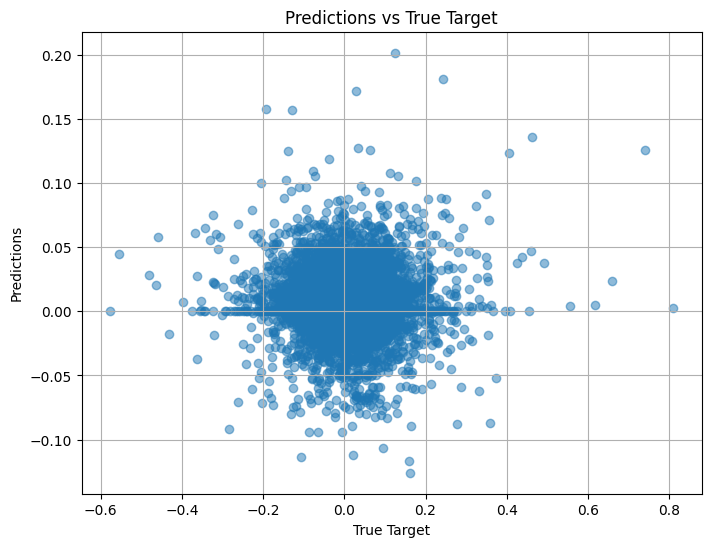

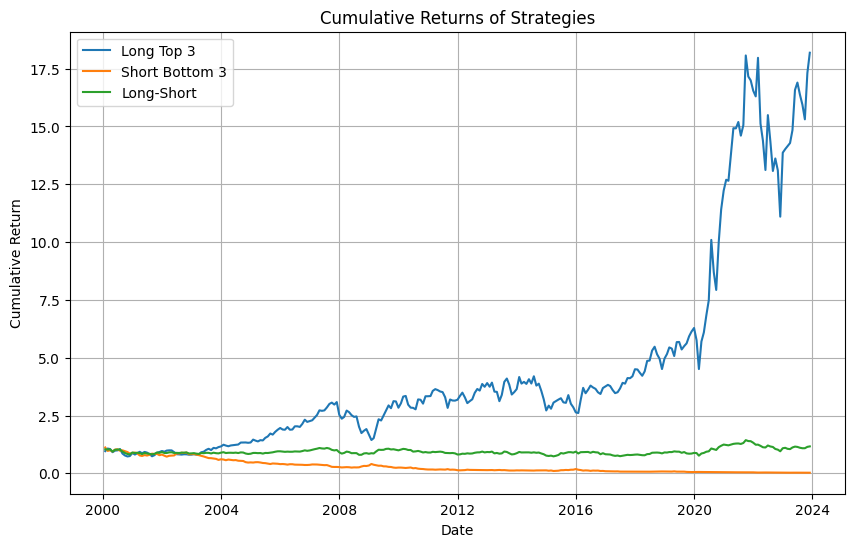

Annualized Sharpe Ratios:
Long Top 3: 0.5749
Short Bottom 3: -0.6287
Long-Short: 0.1149


In [ ]:
import os; import pandas as pd; import numpy as np; from sklearn.metrics import r2_score; import matplotlib.pyplot as plt
from trading_bonds_w_ML_utils import *

df_monthly = pd.read_parquet('bond_trading_stack_monthly.parquet')
predictions,df, cumulative_returns, sharpe_ratio = train_predict_evaluate(
                                    df_monthly, 
                                    XGBoost, 
                                    'xgboost',
                                    train_intervals=[60, 365], 
                                    weights=[0.7, 0.3], 
                                    lookback_days  = 365 * 4, 
                                    base_path = "sub_models/weekly",
                                    trade_cost  = 0 # 0.000_05
                                    )

## 3.2. Testing this approach with other models

In [ ]:
import pandas as pd
df_monthly = pd.read_parquet('bond_trading_stack_monthly.parquet')
from trading_bonds_w_ML_utils import *
predictions,df, cumulative_returns, sharpe_ratio = train_predict_evaluate(df_monthly, LightGBM, 'LightGBM', train_intervals=[60, 365], weights=[0.7, 0.3])

In [ ]:
df_monthly = pd.read_parquet('bond_trading_stack_monthly.parquet')
predictions,df, cumulative_returns, sharpe_ratio = train_predict_evaluate(df_monthly, RandomForest, 'RandomForest', train_intervals=[60, 365], weights=[0.7, 0.3])

In [ ]:
import pandas as pd; df_monthly = pd.read_parquet('bond_trading_stack_monthly.parquet')
from trading_bonds_w_ML_utils import *
predictions = train_predict_evaluate(df_monthly, NeuralNetwork, 'NeuralNetwork', train_intervals=[60, 365], weights=[0.7, 0.3])

# 4. Impact of trading costs 

model created :: type = 60d :: at date = 2004-01-31 00:00:00 under path = sub_models/monthly/60d/xgboost_model_2004-01-31_60.json
model created :: type = 365d :: at date = 2004-01-31 00:00:00 under path = sub_models/monthly/365d/xgboost_model_2004-01-31_365.json
model created :: type = 60d :: at date = 2004-03-31 00:00:00 under path = sub_models/monthly/60d/xgboost_model_2004-03-31_60.json
model created :: type = 60d :: at date = 2004-05-31 00:00:00 under path = sub_models/monthly/60d/xgboost_model_2004-05-31_60.json
model created :: type = 60d :: at date = 2004-07-31 00:00:00 under path = sub_models/monthly/60d/xgboost_model_2004-07-31_60.json
model created :: type = 60d :: at date = 2004-09-30 00:00:00 under path = sub_models/monthly/60d/xgboost_model_2004-09-30_60.json
model created :: type = 60d :: at date = 2004-11-30 00:00:00 under path = sub_models/monthly/60d/xgboost_model_2004-11-30_60.json
model created :: type = 60d :: at date = 2005-01-31 00:00:00 under path = sub_models/mo

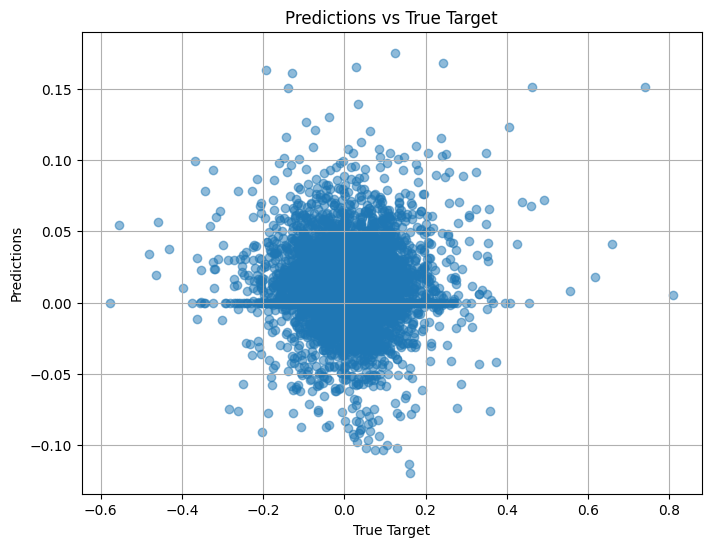

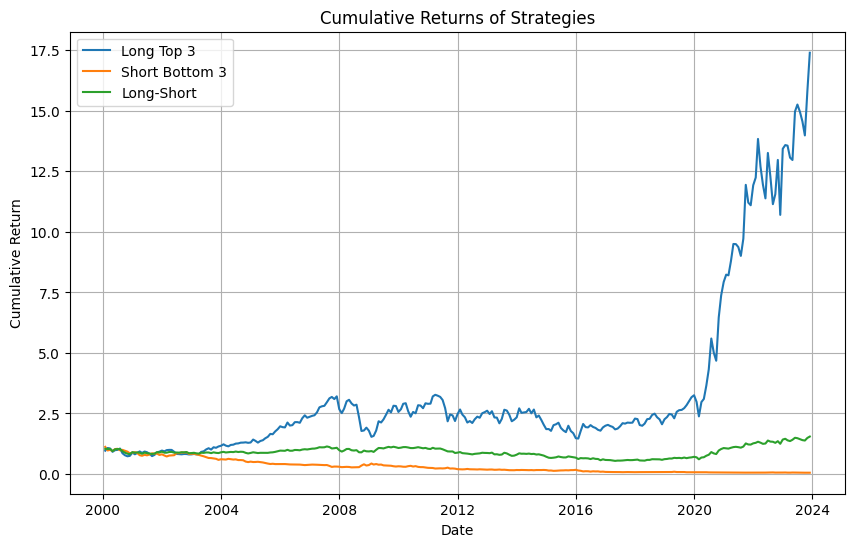

Annualized Sharpe Ratios:
Long Top 3: 0.5566
Short Bottom 3: -0.5623
Long-Short: 0.1990


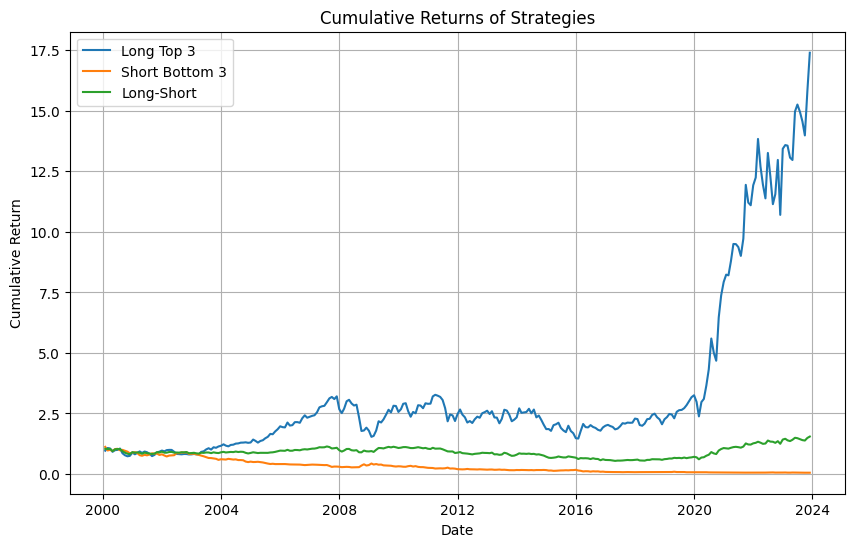

Annualized Sharpe Ratios:
Long Top 3: 0.5566
Short Bottom 3: -0.5623
Long-Short: 0.1990


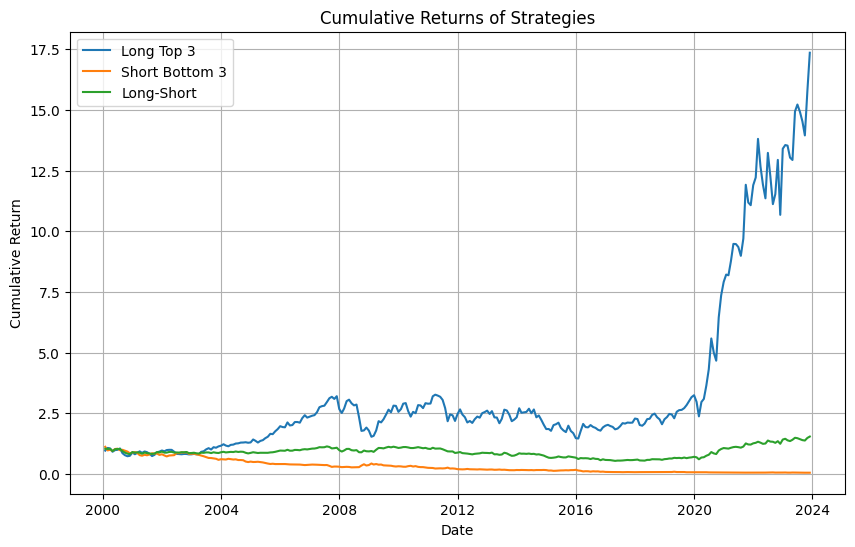

Annualized Sharpe Ratios:
Long Top 3: 0.5562
Short Bottom 3: -0.5629
Long-Short: 0.1982


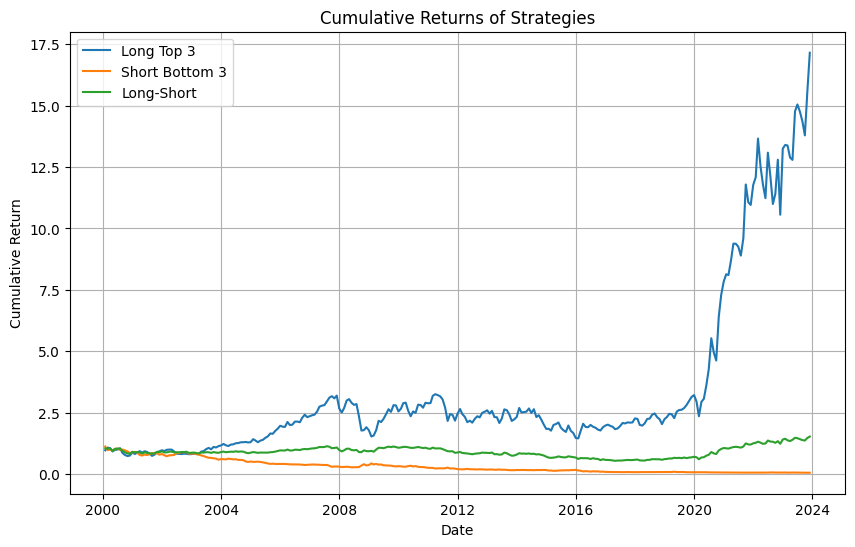

Annualized Sharpe Ratios:
Long Top 3: 0.5546
Short Bottom 3: -0.5655
Long-Short: 0.1947


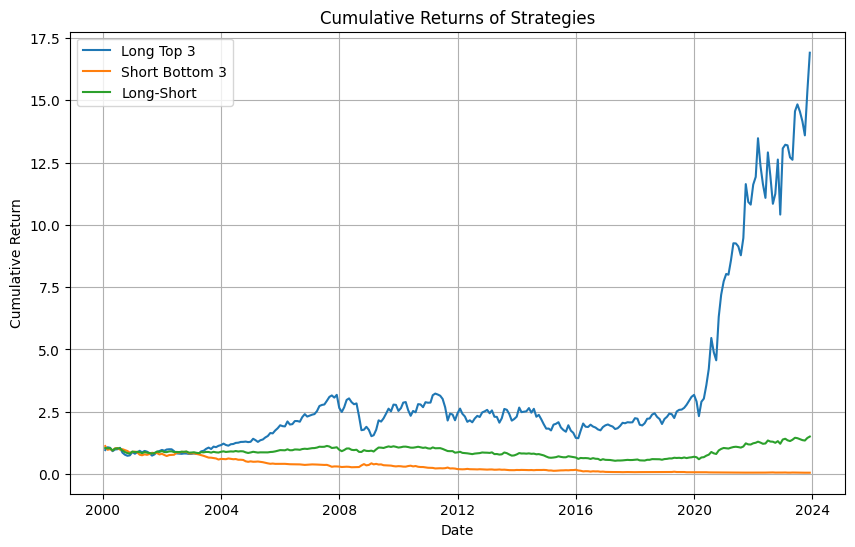

Annualized Sharpe Ratios:
Long Top 3: 0.5525
Short Bottom 3: -0.5687
Long-Short: 0.1905


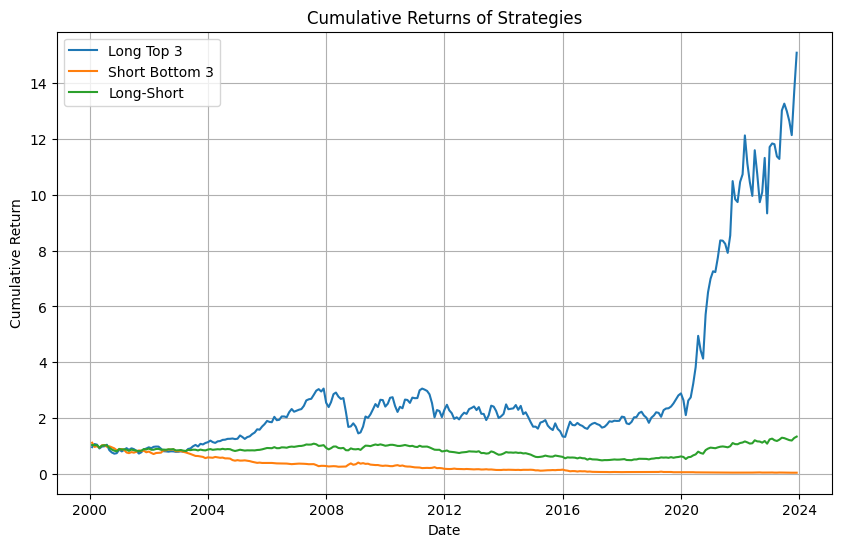

Annualized Sharpe Ratios:
Long Top 3: 0.5359
Short Bottom 3: -0.5944
Long-Short: 0.1562


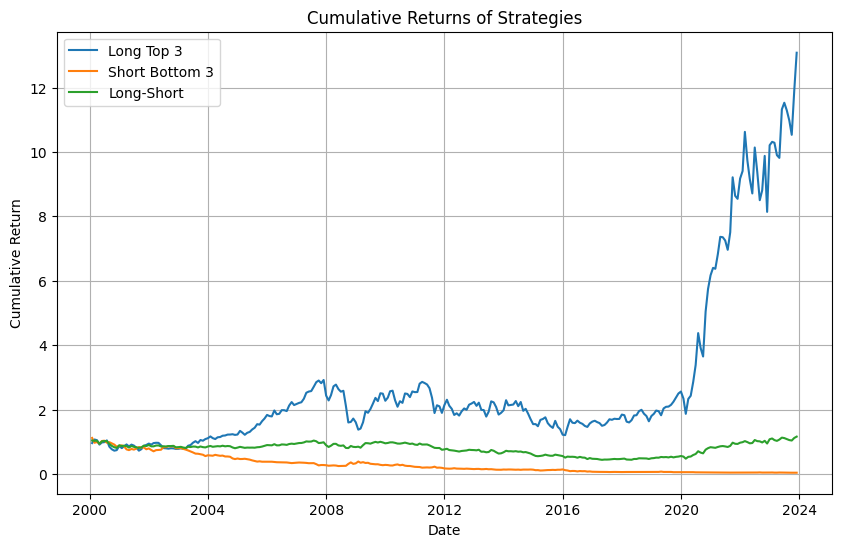

Annualized Sharpe Ratios:
Long Top 3: 0.5151
Short Bottom 3: -0.6266
Long-Short: 0.1134


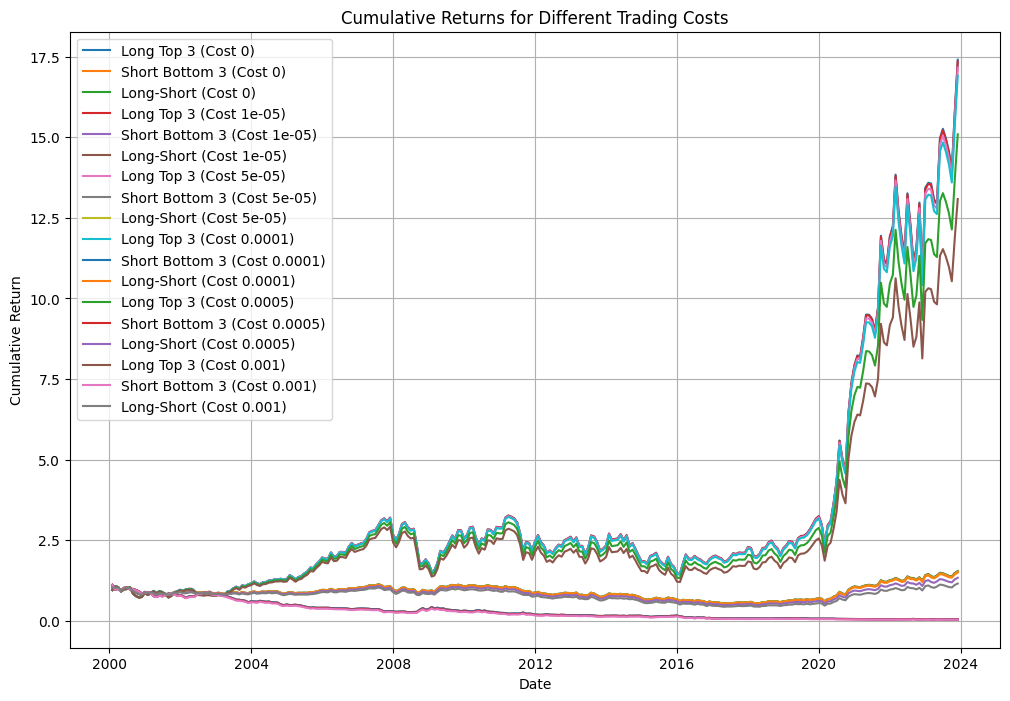

Sharpe Ratios for Different Trading Costs:

Trading Cost: 0
Long Top 3: 0.5566
Short Bottom 3: -0.5623
Long-Short: 0.1990

Trading Cost: 1e-05
Long Top 3: 0.5562
Short Bottom 3: -0.5629
Long-Short: 0.1982

Trading Cost: 5e-05
Long Top 3: 0.5546
Short Bottom 3: -0.5655
Long-Short: 0.1947

Trading Cost: 0.0001
Long Top 3: 0.5525
Short Bottom 3: -0.5687
Long-Short: 0.1905

Trading Cost: 0.0005
Long Top 3: 0.5359
Short Bottom 3: -0.5944
Long-Short: 0.1562

Trading Cost: 0.001
Long Top 3: 0.5151
Short Bottom 3: -0.6266
Long-Short: 0.1134


{0: {'cumulative_returns':             Long Top 3  Short Bottom 3  Long-Short
  2000-01-31    0.960668        1.119755    1.040212
  2000-02-29    1.072761        0.971156    1.031877
  2000-03-31    1.052110        0.995427    1.034839
  2000-04-30    0.915672        0.948420    0.943306
  2000-05-31    0.983935        1.028920    1.018501
  ...                ...             ...         ...
  2023-08-31   14.559935        0.051680    1.398046
  2023-09-30   13.985404        0.052477    1.381238
  2023-10-31   15.814750        0.053761    1.488472
  2023-11-30   17.401458        0.052496    1.545626
  2023-12-31         NaN             NaN         NaN
  
  [288 rows x 3 columns],
  'sharpe_ratios': {'Long Top 3': 0.5566295133176947,
   'Short Bottom 3': -0.5622980289266999,
   'Long-Short': 0.19902415443191773},
  'returns_df':             Long Top 3  Short Bottom 3  Long-Short
  2000-01-31   -0.039332        0.119755    0.040212
  2000-02-29    0.116682       -0.132706   -0.008012
  

In [ ]:
from trading_bonds_w_ML_utils import *
import pandas as pd
df_monthly = pd.read_parquet('bond_trading_stack_monthly.parquet')
predictions,df, cumulative_returns, sharpe_ratio, returns_df = train_predict_evaluate(
                                    df_monthly, 
                                    XGBoost, 
                                    'xgboost',
                                    train_intervals=[60, 365],
                                    weights=[0.7, 0.3],
                                    lookback_days  = 365 * 4,
                                    base_path = "sub_models/monthly",
                                    trade_cost  = 0 # 0.000_05
                                    )
simulate_diff_trading_costs(df, predictions, trade_costs=[0, 0.00001, 0.00005, 0.0001, 0.0005, 0.001])